In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time
from scipy.stats import rankdata
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from scipy.stats import bernoulli

490
496
491
494
499
492
486
497
498
495


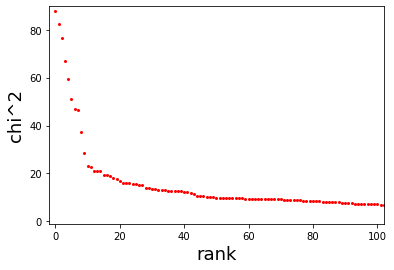

In [2]:
N = 100
M = 500
a = np.zeros(M)
b = np.zeros(M)
m = np.zeros(M)
n = np.zeros(M)

for i in range(M-10):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 1/2)
    b[i] = np.random.binomial(n[i], 1/2)

for i in range(M-10,M):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 3/4)
    b[i] = np.random.binomial(n[i], 3/4)

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if m[i] == 0:
        f = 0
    else:
        f = (2*a[i]-m[i])**2/m[i]
    if n[i] == 0:
        s = 0
    else:
        s = (2*b[i]-n[i])**2/n[i]
    if m[i] + n[i] == N:
        t = 0
    else:
        t = (2*a[i]+2*b[i]-m[i]-n[i])**2/(N-m[i]-n[i])
    
    stats[i] = f + s + t

x = np.argsort(stats)
for i in range(10):
    print(x[M-1-i])

stats = sorted(stats, reverse=True)
#print(sorted_stats)

fig = plt.figure()
plt.ylim(-1, max(stats)+2)
plt.xlim(-2, 102)
plt.plot(order, stats, marker="o", markersize=2, color = "red", linestyle = "None")
#plt.axhline(23.0, color = "black", linestyle = "-.")
plt.xlabel("rank", fontsize = 18)
plt.ylabel("chi^2", fontsize = 18)
fig.savefig("stats_small.png")
fig.savefig("fig/stats-small.eps")

In [3]:
def HaarMatrix(N):
    A = np.zeros((N,N))
    for j in range(0,N):
        A[0,j] = 1/np.sqrt(N)
    for i in range(1,N):
        for j in range(0,N):
            if N*(i-2**(np.floor(math.log2(i))))/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))):
                A[i,j] = 2**(np.floor(math.log2(i))/2)/np.sqrt(N)
            elif N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1)/(2**(np.floor(math.log2(i)))):
                A[i,j] = -2**(np.floor(math.log2(i))/2)/np.sqrt(N)
    return A

In [4]:
def BernoulliMatrix(K,N):
    phi = np.zeros((K,N))
    
    for i in range(K):
        for j in range(N):
            phi[i][j] = bernoulli.rvs(0.5, size=1)

    return (phi - 1/2) / (np.sqrt(K) / 2)

In [5]:
def OMP(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    r = y
    rr = np.dot(r,r)
    
    for i in range(K):
        err = rr - np.dot(A[:,S == 0].T, r) ** 2
        ndx = np.where(S == 0)[0]
        for j in range(K):
            S[j] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
        
        r = y - np.dot(A, x)
        rr = np.dot(r,r)
    
    return x

In [6]:
def determineS(n,d,psi,eta):
    xx = np.dot(psi.T, d)
    
    s = 0
    for i in range(n):
        if xx[i] > eta:
            s += 1
    
    if s == 0:
        s = 10
    
    return s

In [7]:
def CompressiveMechanism(g, deltag, K, epsilon, eta, phiphi, psi, AA, ss, kk):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    d = np.zeros(n)
    for i in range(m):
        d[i] = g[i]
    
    y = np.dot(phiphi, d)
    pri_y = y + np.random.laplace(loc = 0.0, scale = 2*K*deltag*np.sqrt(kk)/epsilon, size=kk)
    
    pri_x = OMP(AA, pri_y, n, ss)
    
    pri_d = np.dot(psi, pri_x)
    pri_g = np.zeros(m)
    for i in range(m):
        pri_g = pri_d
    
    return pri_g

In [8]:
def CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    t = g[int(s)-1]
    
    x = np.zeros(n)
    for i in range(n):
        if i < m and g[i] >= t:
            x[i] = g[i]
        else:
            x[i] = 0
    
    y = np.dot(A, x)
    
    noise = (2*K/epsilon)*np.sqrt(k)*deltag*((1+(np.sqrt(n)-1)*(np.sqrt(2)+1))/np.sqrt(n))
    pri_y = y + np.random.laplace(loc = 0.0, scale = noise, size = k)
    
    pri_x = OMP(A, pri_y, n, s)
    
    pri_g = g + np.random.laplace(loc = 0.0, scale = 2*K*deltag/epsilon, size=m)
    
    for i in range(m):
        if g[i] >= t:
            pri_g[i] = pri_x[i]
    
    return pri_g

In [9]:
def lap_noise_normal(data, K, epsilon):
    pri_data = data + np.random.laplace(loc = 0.0, scale = 2*K*(4*N/(N+2))/epsilon, size=np.size(data))
    
    return pri_data

In [10]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(stats, s, m, K, epsilon):
    h = np.zeros(m)
    for i in range(m):
        h[i] = stats[i]
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * h[i] / (2*K*s))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        h[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [11]:
def accuracy(g, deltag, K, epsilon,eta, s, m, phi, phiphi, psi, A, AA, ss, k, kk):
    correct = np.zeros(4)
    for j in range(10):
        pri_comp_data = CompressiveMechanism(g, deltag, K, epsilon,eta, phiphi, psi, AA, ss, kk)
        pri_comp_rank = rankdata(-pri_comp_data)
        #print(pri_comp_rank[0:20])
        #print(g[0:20])
        
        pri_complap_data = CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k)
        pri_complap_rank = rankdata(-pri_complap_data)
        #print(pri_complap_rank[0:20])
        #print(g[0:20])
        
        pri_lap_data = lap_noise_normal(g, K, epsilon)
        pri_lap_rank = rankdata(-pri_lap_data)
        #print(pri_lap_rank[0:20])
        #print(g[0:20])
        
        pri_exp_rank = exp_mec(g, deltag, m, K, epsilon)
        #print(pri_exp_rank[0:20])
        #print(g[0:20])
        
        for i in range(K):
            if pri_comp_rank[i] <= K:
                correct[0] += 1
            if pri_complap_rank[i] <= K:
                correct[1] += 1
            if pri_lap_rank[i] <= K:
                correct[2] += 1
            if pri_exp_rank[i] < K:
                correct[3] += 1
    
    acc = correct/(K*10)
    return acc

In [12]:
def calc_RE(pri_data, K, M):
    RE = 0
    pri_rank = rankdata(-pri_data)
    for i in range(K):
        for j in range(M):
            if pri_rank[j] == i + 1:
                RE += math.fabs(j-i)
                break
    RE /= K
    return RE

In [13]:
def calc_RE_exp(pri_data, K):
    RE = 0
    for i in range(K):
        RE += math.fabs(pri_data[i] - i)
    RE /= K
    return RE

In [14]:
def RankError(g, deltag, K, epsilon,eta, s, m, phi, phiphi, psi, A, AA, ss, k, kk):
    RE = np.zeros(4)
    for j in range(10):
        pri_comp_data = CompressiveMechanism(g, deltag, K, epsilon,eta, phiphi, psi, AA, ss, kk)
        RE[0] += calc_RE(pri_comp_data, K, m)
        
        pri_complap_data = CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k)
        RE[1] += calc_RE(pri_complap_data, K, m)
        
        pri_lap_data = lap_noise_normal(g, K, epsilon)
        RE[2] += calc_RE(pri_lap_data, K, m)
        
        pri_exp_data = exp_mec(g, deltag, m, K, epsilon)
        RE[3] += calc_RE_exp(pri_exp_data, K)
    RE /= 10
        
    return RE

[[271.6   3.5 268.2 320.7]
 [199.3   5.1 189.9 202.8]
 [242.4   4.2 212.2 210.4]
 [210.2   4.4  87.4  58.9]
 [199.6   5.1   1.2  34.6]
 [165.7   3.7   0.4   1.3]]
[[189.3   5.7 220.8 319.3]
 [211.4   5.1 258.6 263.9]
 [176.8   5.2 185.4 204.9]
 [191.6   3.5 104.  125.7]
 [191.7   5.2   1.    0.7]
 [193.6   4.    0.9   1.3]]
[[225.6   4.8 271.2 223.5]
 [150.3   5.9 218.7 253.4]
 [181.2   5.4 179.1 234.2]
 [197.8   3.5  16.3   6.1]
 [211.4   3.    0.7   1.2]
 [173.    4.3   0.7   0.6]]
[[201.7   4.1 230.7 186.3]
 [236.    5.1 283.1 253.2]
 [175.5   6.5 122.7 250. ]
 [216.7   4.   61.6 193.8]
 [167.4   6.4   0.9   4.6]
 [112.5   3.3   0.6   1.1]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[201.5   5.5 240.  282.2]
 [208.1   4.3 315.2 310.4]
 [142.9   4.2 172.1 255.2]
 [202.    4.6  65.4 127.5]
 [174.9   4.7   0.8   0.6]
 [148.7   5.3   0.7   0.5]]


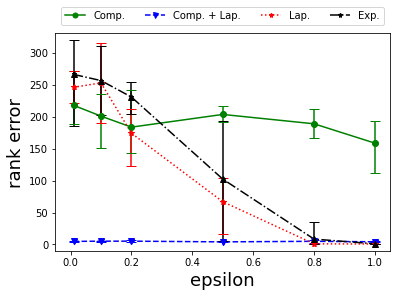

In [15]:
eta = 10
s = 10

n = int(2**(np.ceil(math.log2(M))))
k = int(np.floor(s*math.log(n/s)))

d = np.zeros(n)
for i in range(M):
    d[i] = stats[i]
    
psi = HaarMatrix(n)
ss = determineS(n,d,psi,eta)
kk = int(np.floor(ss*math.log(n/ss)))
    
phiphi = BernoulliMatrix(kk,n)
AA = np.dot(phiphi, psi)

phi = BernoulliMatrix(k,n)
A = np.dot(phi, psi)

K = 1

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 1000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, max([max(max_RE[:,0]), max(max_RE[:,1]), max(max_RE[:,2]), max(max_RE[:,3])])+10)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_small_K=1.png")
fig.savefig("fig/RE_small_K=1.eps")

[[186.66666667   8.         211.3        239.33333333]
 [207.83333333  10.26666667 266.63333333 219.4       ]
 [178.16666667  32.3        229.53333333 224.46666667]
 [183.5          4.46666667 264.16666667 246.43333333]
 [181.16666667   9.06666667 163.3        184.33333333]
 [184.1          8.83333333 165.33333333 164.9       ]]
[[193.4          8.23333333 280.9        231.23333333]
 [182.23333333  28.66666667 257.06666667 250.8       ]
 [156.2          4.2        282.8        231.26666667]
 [167.26666667  18.53333333 260.96666667 237.2       ]
 [207.16666667   6.83333333 152.66666667 230.06666667]
 [220.33333333  18.16666667 249.86666667 163.4       ]]
[[202.73333333  12.         243.06666667 278.76666667]
 [218.          25.3        257.53333333 244.7       ]
 [188.56666667  18.63333333 215.06666667 309.4       ]
 [188.53333333  25.13333333 262.33333333 216.8       ]
 [190.3         21.5        129.63333333 187.3       ]
 [212.26666667   4.2        206.1        189.73333333]]
[[218.5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[203.13333333  22.1        241.56666667 269.7       ]
 [203.83333333  37.7        221.8        242.26666667]
 [210.53333333  19.26666667 171.86666667 302.23333333]
 [199.06666667  26.36666667 254.2        191.83333333]
 [199.66666667   3.46666667 182.9        184.6       ]
 [169.16666667  14.73333333 167.7        247.3       ]]


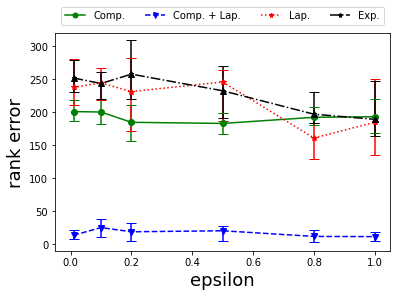

In [16]:
eta = 10
s = 10

K = 3

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 1000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, max([max(max_RE[:,0]), max(max_RE[:,1]), max(max_RE[:,2]), max(max_RE[:,3])])+10)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_small_K=3.png")
fig.savefig("fig/RE_small_K=3.eps")

[[192.    75.88 247.28 244.02]
 [195.44  46.96 236.72 238.1 ]
 [199.7   77.34 242.76 229.64]
 [190.84  56.28 259.92 218.14]
 [188.9   57.96 228.82 240.5 ]
 [196.32  63.14 258.14 199.32]]
[[200.6   88.   275.82 249.08]
 [204.    37.44 274.36 224.3 ]
 [236.98  56.44 235.36 250.62]
 [198.98  54.08 264.94 232.12]
 [192.38  40.92 221.68 231.74]
 [169.2   72.82 185.98 238.96]]
[[197.32  66.8  223.22 251.16]
 [200.5   42.76 225.24 226.48]
 [186.22  75.78 273.38 241.16]
 [198.16  53.28 253.46 232.58]
 [172.86  25.26 214.66 224.02]
 [169.1   43.2  253.96 206.96]]
[[157.    98.16 259.18 241.2 ]
 [213.04  59.92 238.62 248.44]
 [194.72  47.08 253.92 236.76]
 [199.74  30.96 214.84 206.06]
 [191.46  39.54 207.62 216.06]
 [167.22  29.44 238.46 263.02]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[187.72  35.66 243.68 292.72]
 [191.56  34.98 243.3  254.8 ]
 [196.7   52.6  293.6  239.3 ]
 [212.88  69.02 214.08 271.44]
 [199.76  48.96 229.1  243.66]
 [210.08  66.06 197.08 213.3 ]]


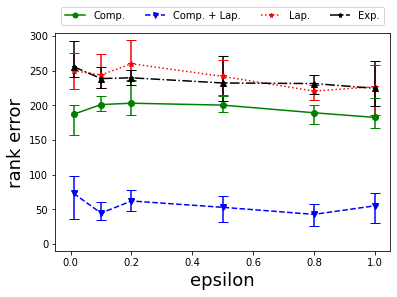

In [17]:
eta = 10
s = 10

K = 5

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 1000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, max([max(max_RE[:,0]), max(max_RE[:,1]), max(max_RE[:,2]), max(max_RE[:,3])])+10)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_small_K=5.png")
fig.savefig("fig/RE_small_K=5.eps")

[[184.93 136.4  255.3  260.44]
 [202.31 147.85 248.31 234.75]
 [189.34 158.3  242.55 217.71]
 [195.94 140.92 251.75 232.81]
 [189.1  149.94 224.59 253.26]
 [211.1  147.93 230.89 247.47]]
[[187.29 160.76 250.73 246.31]
 [188.77 141.45 226.16 252.35]
 [194.76 161.57 250.48 243.5 ]
 [194.62 146.53 227.87 242.51]
 [183.4  120.41 238.19 215.22]
 [185.39 128.68 227.68 240.3 ]]
[[206.28 137.9  251.06 232.07]
 [191.19 115.93 255.75 256.81]
 [191.63 161.25 260.21 237.13]
 [198.   151.83 221.58 249.28]
 [196.95 132.78 225.52 250.59]
 [185.41 163.65 220.8  213.69]]
[[183.97 131.66 244.44 220.87]
 [189.3  135.23 227.63 253.83]
 [201.22 150.86 225.99 250.21]
 [189.51 141.16 261.72 238.69]
 [176.4  129.17 254.19 238.12]
 [197.62 121.31 216.11 267.05]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[183.91 138.48 246.1  240.75]
 [201.72 169.57 252.36 263.15]
 [191.85 149.31 250.58 229.72]
 [201.65 125.53 243.61 215.22]
 [187.87 108.5  210.73 233.24]
 [190.52 152.14 231.95 239.31]]


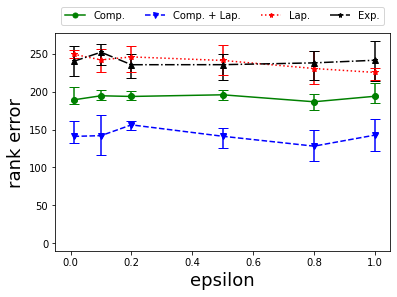

In [18]:
eta = 10
s = 10

K = 10

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 1000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, max([max(max_RE[:,0]), max(max_RE[:,1]), max(max_RE[:,2]), max(max_RE[:,3])])+10)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.5, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=10)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_small_K=10.png")
fig.savefig("fig/RE_small_K=10.eps")